### **Part 1: Exploratory Data Analysis**

In [1]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
logins_df.set_index('login_time', inplace=True)
logins_df['login_counts'] = np.ones(len(logins_df))
logins_df.head()

,login_counts
login_time,
1970-01-01 20:13:18,1.0
1970-01-01 20:16:10,1.0
1970-01-01 20:16:37,1.0
1970-01-01 20:16:36,1.0
1970-01-01 20:26:21,1.0


**Aggregating login counts based on 15­ minute time intervals**

In [6]:
logins_df_15min = logins_df.resample('15T').sum()
logins_df_15min.head()

,login_counts
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [7]:
logins_df_15min['time'] = logins_df_15min.reset_index()['login_time'].dt.time.tolist()
logins_df_15min['day_of_week'] = logins_df_15min.reset_index()['login_time'].dt.dayofweek.tolist()
logins_df_15min['month'] = logins_df_15min.reset_index()['login_time'].dt.month.tolist()
logins_df_15min.reset_index(drop=True, inplace=True)
logins_df_15min.head()

,login_counts,time,day_of_week,month
0,2.0,20:00:00,3,1
1,6.0,20:15:00,3,1
2,9.0,20:30:00,3,1
3,7.0,20:45:00,3,1
4,1.0,21:00:00,3,1


Let's take a look at the daily average number of logins by the time of day across all days of the week. 

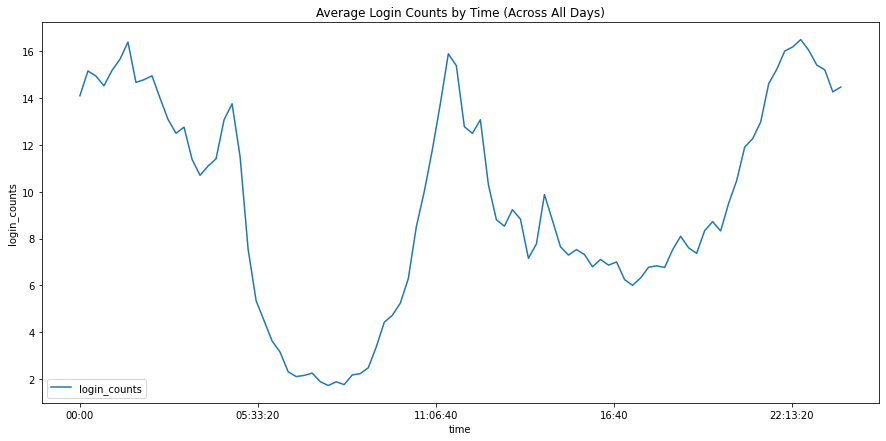

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
logins_df_15min.groupby(['time']).mean().reset_index().plot(x='time', y='login_counts', ax=ax)
ax.set_ylabel('login_counts')
ax.set_title('Average Login Counts by Time (Across All Days)')
plt.show()

From here we see generally there are two peaks for each day. One during late night/early morning and the other one during the mid-day. Let's see how this will vary from day to day throughout the week.

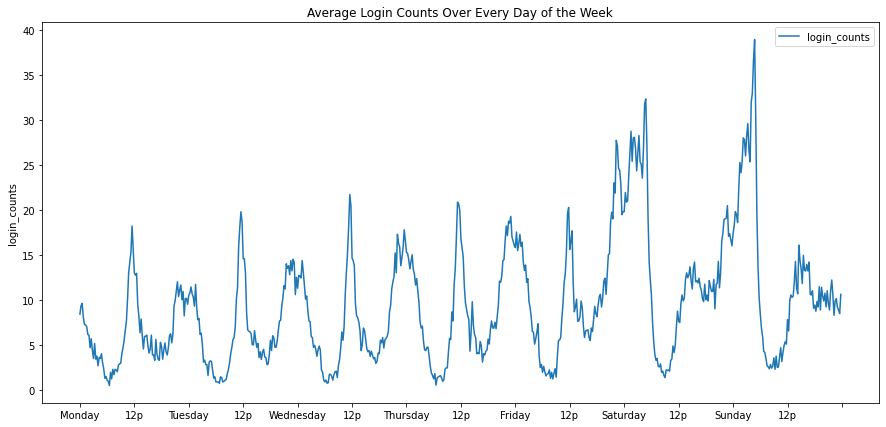

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
logins_df_15min.groupby(['day_of_week', 'time']).mean().reset_index().plot( y='login_counts', ax=ax)
ax.set_xticks(range(0, 673, int(672/14)))
ax.set_xticklabels(['Monday', '12p', 'Tuesday', '12p', 'Wednesday', '12p', 'Thursday', '12p', 'Friday', '12p', 'Saturday', '12p', 'Sunday', '12p'])
ax.set_ylabel('login_counts')
ax.set_title('Average Login Counts Over Every Day of the Week')
plt.show()

There is a steady increase in the total number of daily logins from Monday to the rest of the week. Let's take a closer look a each day. 

In [10]:
# Resample by day to count total daily average number of logins
logins_df_day = logins_df.resample('D').sum()
logins_df_day['day_of_week'] = logins_df.resample('D').sum().reset_index()['login_time'].dt.dayofweek.tolist()
logins_df_day.head()

,login_counts,day_of_week
login_time,,
1970-01-01,112.0,3
1970-01-02,681.0,4
1970-01-03,793.0,5
1970-01-04,788.0,6
1970-01-05,459.0,0


In [11]:
def plot_days(day):
    '''make a plot of the number of logins vs day, where day is a number 0-6 starting with monday and annotate 
        the plot with the total daily average for that day'''
    fig, ax = plt.subplots(figsize=(16,8))
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df = logins_df_15min.groupby(['day_of_week', 'time']).sum().loc[day].reset_index()
    df.plot(x='time', y='login_counts', legend=False, ax=ax)
    
    daily_avg = int(logins_df_day.groupby(['day_of_week']).sum().loc[i]
                    / logins_df_day.day_of_week.value_counts()[i])
    y=df.login_counts.min()
    ax.annotate('{} average total logins: {}'.format(days[i], daily_avg), xy=(0, 50), xytext=(60000, y), size=14)
    ax.set_title(days[day])
    ax.set_ylabel('login_count')

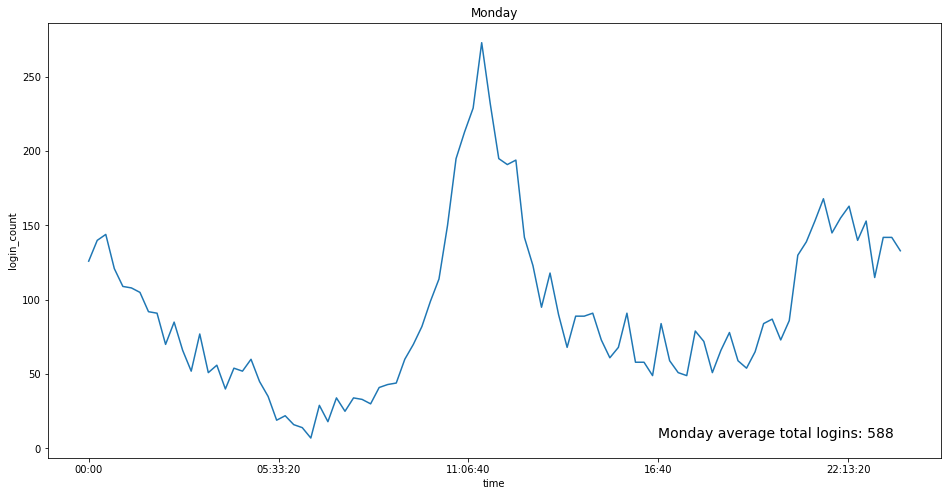

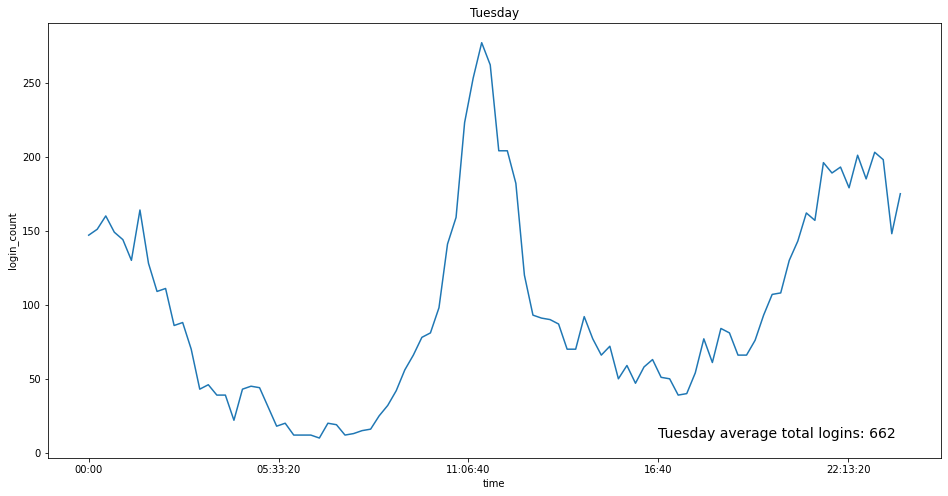

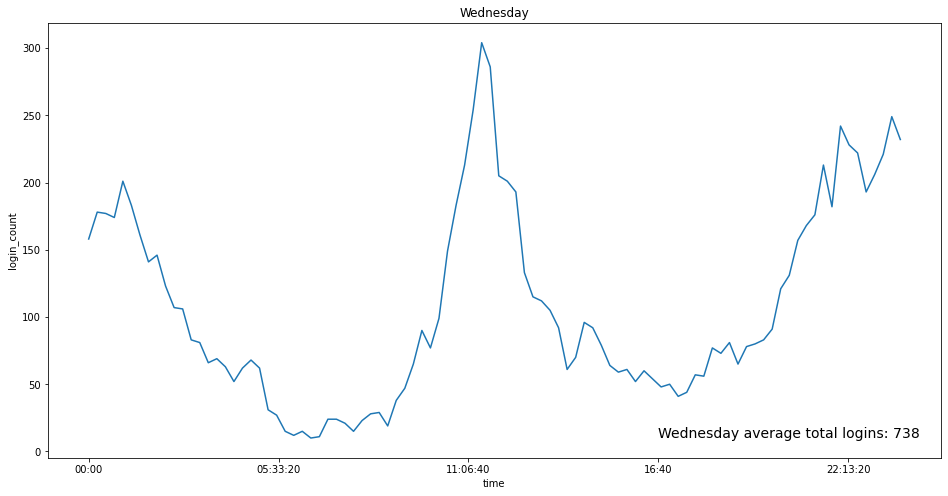

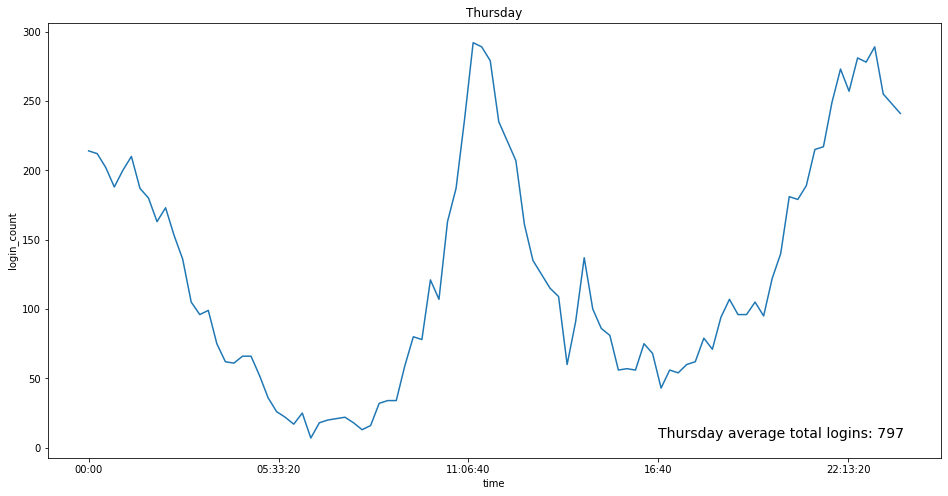

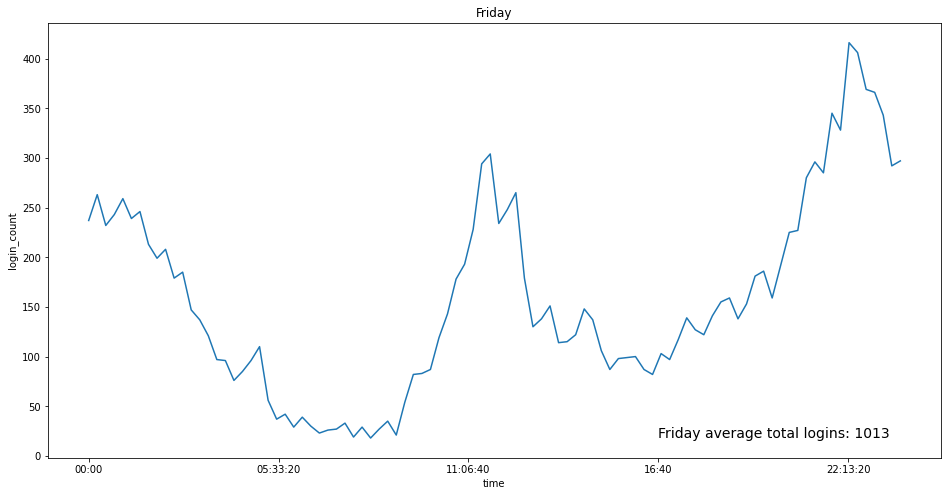

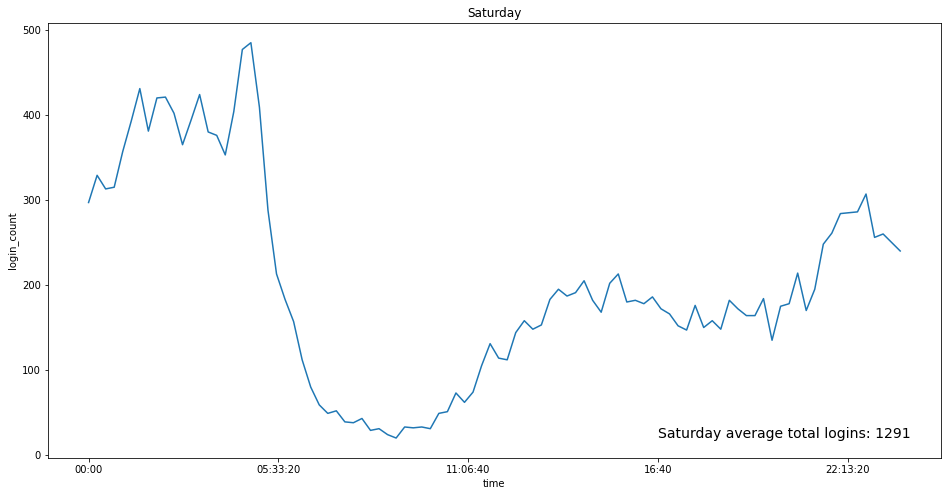

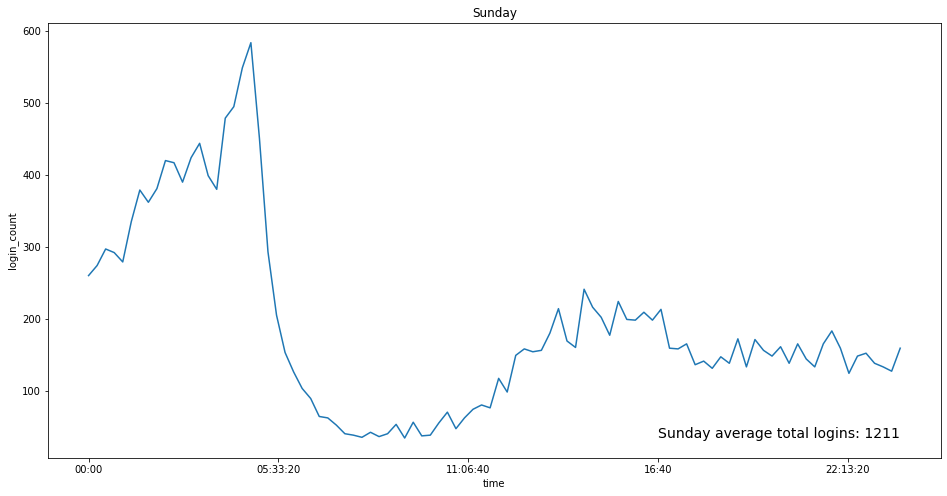

In [12]:
for i in range(7):
    plot_days(i)

The trend for the number of logins versus the time of day seems to be pretty consistent from Monday through Friday with peak amount of traffic during late night/early morning and mid-day. This changes during the weekend where the peak is in the early morning and stays steady throughout the afternoon. There does not seem to be any issue regarding quality of the data.

### **Part 2: Experiment and metrics design**

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


 **1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**

The metric/test statistic I would choose for this experiment would be to determine the change in pre and post reimbursement based on the number of times a driver crossed the bridge. This will help to indicate whether there is an increase, decrease, or change in how often driver partners served both cities after the experiment. 

A successful post-reimbursement increase in drivers crossing supports the experiment's success - Driver partners tend to serve both cities more often after introduction to experiment. 

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**Implementing Experiment**

Conduct one-sided, 1 sample z-test where sample size is assumed to be > 30 drivers. Compare the number of driver bridge crossings pre and post toll reimbursement. 

*  $H_0$: No difference in driver bridge crossings, after toll reimbursement experiment.
*  $H_A$: Increase in driver bridge crossings, after toll reimbursement experiment.

Null hypothesis distribution is the number of driver crossings before the toll reimbursement experiment.

1. Calculate z-score of the average frequency of drivers serving both cities, post toll reimbursement experiment. 
2. Set $a$=0.05. Determine whether the z-score's p-value falls below this significance threshold. 


**Interpreting Results**

If p-value < 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would help support a significant increase in driver bridge crossings after the toll reimbursement gets introduced, indicating that this policy was a success. 

**Recommendations and Caveats**

I recommend to only consider the policy a success if the margin is wide enough and a p-value far below 0.05. It is obvious that a significance post-reimbursement increase has occurred even in the middle of all the fluctuations. 

The caveat is that the $a$ significance levels are set arbitrarly and p-values fluctuate depending on sample size. Depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.

###**Part 3: Predictive Modeling**

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

In [13]:
df_users = json.load(open('ultimate_data_challenge.json')) # load json (produces dict)
df_users = pd.DataFrame(df_users) # convert json dict to dataframe
print('Number of users: ', len(df_users))
df_users.head()

Number of users:  50000


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


**Data cleaning, exploratory analysis, visualizations**



1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

**Get cutoff for retained users**

Users are retained if at the time of data pulling, they were active in the last 30 days.

In [14]:
from datetime import timedelta
from dateutil import parser

# Get latest date that data was pulled
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date']) # convert 'last_trip_date' column to datetime
date_pulled = max(df_users['last_trip_date']) # get max = approximation of when data was pulled

# Get cutoff for earliest active date to meet "retained" criteria
retain_cutoff = date_pulled - timedelta(days=30)

print("Cut-off for 'retained users': ", retain_cutoff)

Cut-off for 'retained users':  2014-06-01 00:00:00


**Get fraction of observed users retained**

In [15]:
df_retained = df_users[df_users['last_trip_date'] >= retain_cutoff]
print("Fraction of observed users retained: ", len(df_retained) / len(df_users))

Fraction of observed users retained:  0.37608


## **Building a Predictive Model**

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?

**Get users still active in their 6th month on the system**

In [16]:
# Setup
df_users['signup_date'] = pd.to_datetime(df_users['signup_date']) # convert dates to datetime objects
month_6 = df_users['signup_date'] + timedelta(days=151) # set minimum date of last ride to qualitfy as "active in their 6th mo"

# Get users active in their 6th month in system
active_idx = [idx for idx, s in enumerate(df_users['last_trip_date']) if s > month_6[idx]] # their their indices in database

# Append data to our database (useful for data viz later)
df_users['active'] = 0 # set default to 0
df_users.loc[active_idx, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_idx))
print("Number of inactive users: ", len(df_users) - len(active_idx))
print("Percent active users: ", len(active_idx)/len(df_users))

Number of active users:  11694
Number of inactive users:  38306
Percent active users:  0.23388


Only about 23% of users are active. We probably cannot rely on the accuracy alone for determining how effective our model is. We will also need metrics such as % false positives and false negatives.

### Data Cleaning, Pre-processing, & EDA

Clean data/fill in missing data, feature scaling, drop irrelevant features, etc while inspecting the data.

#####**Convert columns with string values to int**

  Inspect which values consist of string values

In [17]:
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Check number of unique values in each of these columns


In [18]:
print("city: ", df_users['city'].unique())
print("phone: ", df_users['phone'].unique())
print("ultimate_black_user: ", df_users['ultimate_black_user'].unique())

city:  ["King's Landing" 'Astapor' 'Winterfell']
phone:  ['iPhone' 'Android' None]
ultimate_black_user:  [ True False]


Convert to int
- city: {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
- phone: {"iPhone": 1, "Android": 2, "None": 0}
- ultimate_black_user: {"True": 1, "False": 0}

In [19]:
# Convert cities
cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
df_users['city'] = df_users['city'].map(lambda x: cities[x])

# Convert phones
phones = {"iPhone": 1, "Android": 2}
df_users['phone'] = df_users['phone'].map(lambda i: phones[i] if i is not None else 0)

# Convert ultimate black status
df_users['ultimate_black_user'] = df_users['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

**Replace Missing Values**

There are some missing values in some of the columns. To deal with these missing values, we'll replace them with the column mean.

In [20]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  50000 non-null  int64 

In [21]:
df_users['avg_rating_by_driver'].fillna(df_users['avg_rating_by_driver'].mean(), inplace=True)
df_users['avg_rating_of_driver'].fillna(df_users['avg_rating_of_driver'].mean(), inplace=True)

**Determining features to keep**

Since some of our features are encoded differently and that some others may be interrelated, we should determine which features to take out of our model simplify it and to minimize confounding. 

**Inter-feature correlations**

We need to make sure that none of our features are correlated with one another. For convenience, though, our correlation matrix also includes row/column for 'active' users - allowing us to easily visualize whether any individual features strongly predict 'active' users. 

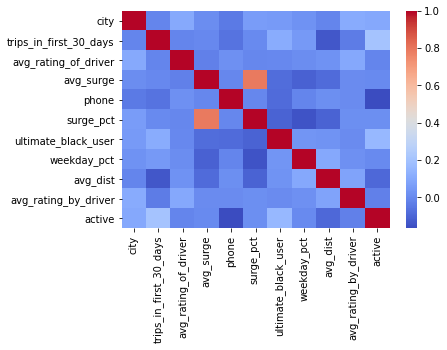

In [22]:
sns.heatmap(df_users.corr(), cmap="coolwarm");

Based on these results, we will throw out

*   **surge_pct** and **avg_surge**: The only features with a high inter-correlation are both 'surge_pct' and 'avg_surge' makes sense. Users who tend to take trips during surge will have higher % of trips with surge ('surge_pct') and higher average surge ('avg_surge'). Since neither are strongly correlated with the 'active' users, we drop these to avoid confounding our model.
*   **phone**: very low correlation (~0) with 'active' users. Additionally, it might confound our model since its values are encoded by an arbitrary binary conversion and most of our features are continuous.



**Inspect select features more closely**

There are few discrete features that we're unsure about: **'city'** and **'ultimate_black_user'**. We would like to throw them out if they don't seem significant in contributing to the prediction of 'active' users. (Since discrete features might confound our model of majority continuous features). Let's inspect them more closely.

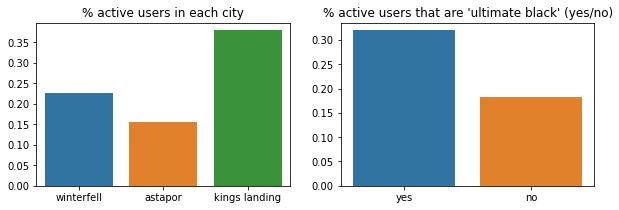

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# % active users by city

df1 = df_users[df_users['city']==1]
df2 = df_users[df_users['city']==2]
df3 = df_users[df_users['city']==3]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)
active3 = len(df3[df3['active']==1])/len(df3)

g = sns.barplot(x = ['winterfell', 'astapor', 'kings landing'], y = [active1, active2, active3], ax=ax1);
g.set_title('% active users in each city');

# % active users by "ultimate black" status

df1 = df_users[df_users['ultimate_black_user']==1]
df2 = df_users[df_users['ultimate_black_user']==0]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)

g = sns.barplot(x = ['yes', 'no'], y = [active1, active2], ax=ax2);
g.set_title("% active users that are 'ultimate black' (yes/no)");

They might still be worth keeping. There seem to be differences. Although whether these differences are significant remains unclear.

**Drop selected features**

We have determined that we should drop **'surge_pct'**, **'avg_surge'**, and **'phone'**.

We also would like to drop **'last_trip_date** and **'signup_date'**, since these were used to determine whether the user was active and may no longer be useful. We might be interested in the # of days between the last trip and signup date, but this is susceptible to a lot of confounding factors so for the sake of simplicity, we should just drop it. 

In [24]:
df_users.drop(['surge_pct', 'avg_surge', 'phone', 'last_trip_date', 'signup_date'], inplace=True, axis=1)

Here is our dataset now:


In [25]:
df_users.head()

,city,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,3,4,4.7,1,46.2,3.67,5.0,0
1,2,0,5.0,0,50.0,8.26,5.0,0
2,2,3,4.3,0,100.0,0.77,5.0,0
3,3,9,4.6,1,80.0,2.36,4.9,1
4,1,14,4.4,0,82.4,3.13,4.9,0


### **Scale features**

Inspect distribution of data, determine which feature scaler is best to use, then scale features.

**Check distribution of features**

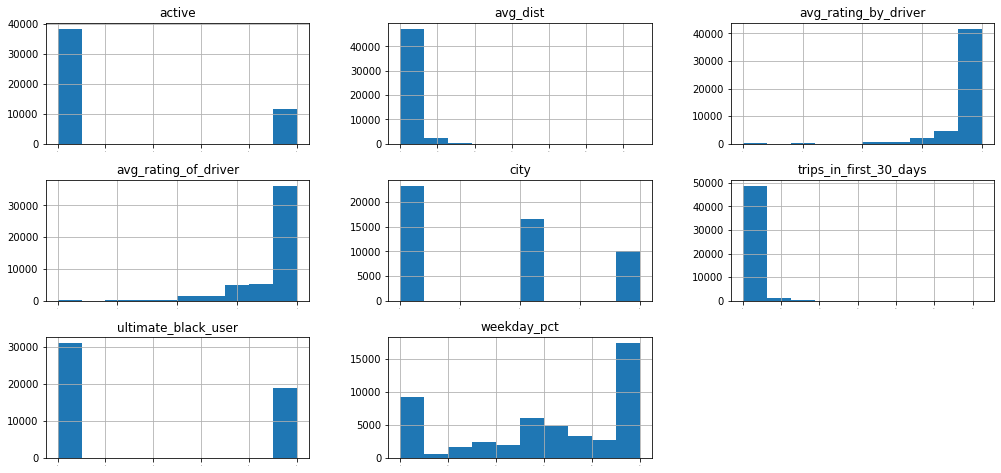

In [26]:
df_users.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8));

**Which feature scaler?**

There are a couple of feature scalers we could use:
*   **Standard scaler**: Assumes the feature is normally distributed, scales them to center around 0 and standard deviation of 1. However, from the above plot, we can see that almost none of are features are normally distributed. Especially with our discretely coded features. 
*   **Min-max scaler**: Shrinks the range of each feature to (0,1) or (-1,1) if there are negative values. IT works better for data that aren't normally distributed. 

So we will use Min-max scaler.

In [27]:
from sklearn.preprocessing import MinMaxScaler

x = df_users.drop('active', axis=1)
y = df_users['active']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

## **Modeling**

We are trying to predict whether a user will still be active or not 6 months in the system. (i.e. a binary classifier) We will first try a few different classifiers, pick the best-performing one, then optimize the hyperparameters to improve performance. 

**Determining cross-validation scores: importance of FP**

Ultimate's priority might probably be to detect whether a customer will churn. The cost that is invested in preventing them from churning probably involves increasing marketing and alerts to help prevent churning behavior. 

As a result of this, we would probably be more concerned about false positives rather than false negatives. It's safer to target ads to anybody who is remotely at-risk for churning. The worst that could happen is that an 'active' user is mislabeled as 'inactive' and therefore would received targeted ads that an at-risk churner would receive - detected as a false negative. 

To look at it subjectively, we would consider that acceptable and not likely to affect 'active' users. Although we would recommend monitoring whether it does so in the future since it is a crucial assumption. 

Our goal is to minimize our rate of false positives - i.e. minimizing the # of churners (not active) who are incorrectly predicted as non-churners(active). Since there are customers that Ultimate would probably be interested in targeting. We should examine the confusion matrix resulting from each of our ML approaches. 

We however don't want a situation where there are too many 'active' users getting annoying ads. Otherwise, then there might end up being a significant number of them who churn later on. So we should also look for false negatives as well. 


In [28]:
# Split the data into training and testing sets before modeling

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

**Logistic Regression**

We were unsure whether some of the features will be important, so we use regularization to reduce the weight of the less important features. Even more tightly, we use L1 (Lasso) Regression in the case of that unimportant features can be eliminated from the model. 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Instantiate model
model = LogisticRegression(penalty='l1',solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(x_test)

# Generate confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion matrix:
[[11230   202]
 [ 3280   288]]


202 of churners were incorrectly labeled as 'active' users. There are also many active users that have been misclassified as churners (false negatives, 3280) Let's move on to other ML approaches to see how they compare.  

**Decision Trees**

Testing different methods based on decision trees: regular decision tree, bagging, random foresting, and boosting. Then we pick the one with the best metrics. 


**Make a custom scoring function**

We are most interested in reducing false positives (churned users incorrectly identified as 'active'), while ensuring low false negative rates (the active users incorrectly identified as churned), since too many active users would be incorrectly spammed to "retain" them.

We want to identify any model that is an improvement over our previous logreg model (FP: 202, FN: 3280). So we write a custom scoring function that takes any model with FP < 202, FN < 3280. From this group of models, GridSearchCV will then identify the model with lowest total FP + FN as the "best" model.


In [30]:
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

# Define scorer
def false_total(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    false_p = matrix[0,1]
    false_n = matrix[1,0]
    if ((false_p < 202) & (false_n < 2000)):
        falses = (false_p+false_n)/sum(sum(matrix))
        return falses
    else:
        falses = 1
        return falses

# Make scorer
scorer = make_scorer(false_total, greater_is_better=False)

**Regular Decision Tree**

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Decision tree
score = scorer
tuned_parameters = {'max_depth':range(2,7)}
model = DecisionTreeClassifier(min_samples_split=100, max_features='sqrt', random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=scorer, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 2} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2}
-1.000 (+/-0.000) for {'max_depth': 3}
-0.535 (+/-0.759) for {'max_depth': 4}
-1.000 (+/-0.000) for {'max_depth': 5}
-0.844 (+/-0.624) for {'max_depth': 6}

Detailed classification report:
[[11432     0]
 [ 3568     0]] 



Although we have 0 churned users incorrectly identified as 'active' now, we  now have too many 'active' users incorrectly identified as churners. This means a lot of active customers will receive spam. We'll move on to other methods that are typically improved versions of decision trees.


**Bagging**

Constructs multiple trees and picks best-performing one.


In [32]:
%%time

from sklearn.ensemble import BaggingClassifier

score = scorer
tuned_parameters = {'n_estimators':range(30,91,10)}
model = BaggingClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'n_estimators': 30} 

Grid scores on development set:
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Detailed classification report:
[[10080  1352]
 [ 2274  1294]] 

CPU times: user 2min 2s, sys: 125 ms, total: 2min 2s
Wall time: 2min 2s


False negatives (active users incorrectly identified as churned), but we still have 1352 false positives (churned users we missed and incorrectly labled as 'active').



**Random Forest**

Constructs multiple decision trees (specified by 'n_estimators') and then picks the best one. When forming a tree, at each node a subset of features are randomly selected out of the total features. The best split feature from this subset is used to split the node (vs. bagging, where all features considered for splitting a node).


In [33]:
%%time

from sklearn.ensemble import RandomForestClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10), 'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 6, 'min_samples_split': 900, 'n_estimators': 20} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 40}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 50}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 60}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 70}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 80}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 90}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
-0.232 

The number of FN is much lower, which means fewer active users will be incorrectly identified as churners/spammed to "retain" them. the number of FP is higher than logistic regression and our optimal random forest model.

**Naive Bayes**

It is rooted in probability (Bayes theorem) and generates predictions based on the past data. Given prior training data with features and labelled outcomes, what can we predict with our set of test observations and their features? The label it predicts for each observation is based on its calculation of the likeliest out of the possible labels.

In [34]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Create the predicted tags: pred
y_true, y_pred = y_test, nb_classifier.predict(x_test)

print(confusion_matrix(y_true, y_pred))

[[11432     0]
 [ 3568     0]]


There are no FP, but there are too many FN, It has the same result as one of our less optimal models earlier.


**Feature importances**

Our final model is a Random Forest Classifier, with {'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30}. This helpa to balance our lowest number of false positives (195, churned users incorrectly identified as 'active') and false negatives (3215, 'active' users incorrectly identified as churned).

Let's look at the most important features.

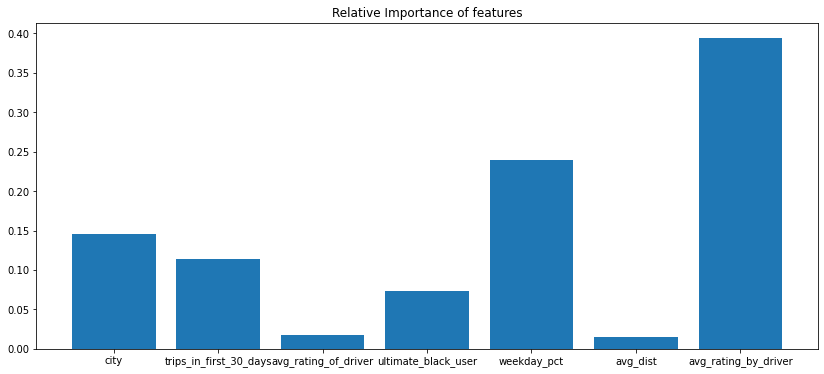

In [35]:
# Recreate our best model
model = RandomForestClassifier(max_depth=4, min_samples_split=100, n_estimators=30, random_state=99)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(x_test)

# Plot relative importance of features
plt.figure(figsize=(14,6));
plt.bar(df_users.columns[:-1].tolist(), model.feature_importances_);
plt.title('Relative Importance of features');

The most important features appear to be average rating by driver (**'avg_rating_by_driver'**) and % of user's trips occurring during weekday(**weekday_pct**).


### **Results**

Approach: Ultimate's goal is to predict rider retention. This means that presumably they would like to predict users at risk for churn and then targeting them for marketing campaigns, discounts, getting in touch, etc. that would retain these users.

As a result, our model emphasizes minimizing false positives (churned users misclassified as 'active' and thus missed by marketing campaigns, etc), while balancing a reasonable amount of false negatives ('active' users misclassified as churners who would then get spammed with these marketing campaigns).

Predicting churned users. Our final model is a Random Forest Classifier, with {'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30}. This model does a good job of predicting churned users, with only 1.3% of churners being misclassified as 'active'.

* The cost is that 21.4% of active users are misclassified as churners, which means they could receive marketing targeted towards churners. However, if this does not result in active users churning (presumably Ultimate adds value sufficiently that they are active users), then this is not necessarily an issue.

* Ultimate should do further tests to determine how detrimental false negatives are.  Will active users necessarily churn because they receive ads as well? And at what frequency of ads would active users begin to churn? A balance can probably be struck.

### **Discussion**

How should Ultimate leverage these insights to improve its longterm rider retention?

The features that were most predictive of 'active'/'inactive' were average rating by driver</i> and percent of user's trips occurring during weekday</i>. As a result, our further recommendations to Ultimate are:



*   **Promote a positive driver-rider interaction** - The lower the average rating is for drivers, the more risk there is of rider churning. Riders must have had dissatisfactory experiences. Drivers should be encouraged to offer some amenities that don't cost too much - like water or candy. They should also be encouraged to ask a standard set of questions that could help to improve the overall rider mood which can reduce the chance of a having a bad interaction. (i.e. asking about AC, choice of music). Therefore the average rating by driver may improve, resulting in less churning. 
*   **Target churners with some weekday discounts** - From our analysis, the percent of user's trips during the week is the important predictor of churning. The increase in the number of weekday trips a churner takes may improve the chance of them still remaining customers. This could be accomplished by offering them weekday discounts for their Ultimate trips, which in turn makes using Ultimate more of a weekday routine for them, therefore increasing the chance they will remain active users. 
*   **Extend weekday discounts for the worst churners** - Even though there are some cases where a churner stays only if there is a weekly discount, if Ultimate is not losing revenue on these customers that would otherwise not be using their service and are price-sensitive, it may be useful to extend discounts for select churners. We recommend for Ultimate to identify the most price-sensitive churners.
